In [1]:
import numpy as np
import gym
import torch
import torch.nn as nn
import torch.functional as F
import matplotlib.pyplot as plt
from IPython import display
from matplotlib import style

plt.style.use("ggplot")


In [2]:
# init environment
env_name = "BipedalWalker-v3"
env = gym.make(env_name)
action_space_size = env.action_space.shape[0]
state_space_size = env.observation_space.shape[0]
print(action_space_size, state_space_size)


4 24


In [3]:
env.reset()

for i in range(5):
    total_reward = 0
    while True:
        _, reward, done, _ = env.step(env.action_space.sample())
        total_reward+= reward
        if done:
            print(f"episode {i+1}, reward: {total_reward}")
            env.reset()
            break


episode 1, reward: -117.5052357450584
episode 2, reward: -96.18302218835413
episode 3, reward: -98.40513596884286
episode 4, reward: -82.043928693497
episode 5, reward: -100.33928265233742


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device", device)
n = 2


device cuda:0


In [ ]:
# load expert model
from stable_baselines3 import SAC
from stable_baselines3.sac import MlpPolicy
from stable_baselines3.common.evaluation import evaluate_policy

expert = SAC.load('./sac-expert-pedelwalker.zip')
NUM_EXPERT_TRAJS = 500
TRAJ_MAX_LENGTH = 500
expert_states = []
while len(expert_states) < TRAJ_MAX_LENGTH:
    # print(len(expert_states))
    traj = []
    obs = env.reset()
    while True:
        action = expert.predict(obs)[0]
        new_obs, _, done, _ = env.step(action)
        traj.append(obs.tolist())
        obs = new_obs
        if len(traj) >= NUM_EXPERT_TRAJS:
            expert_states.append(traj)
            break
        elif done:
            break

In [ ]:
states_new_agent = []
actions_new_agent = []
count = 0
while count < TRAJ_MAX_LENGTH * TRAJ_MAX_LENGTH:
    obs = env.reset()
    states = []
    actions = []
    while True:
        action = env.action_space.sample()
        states.append(obs.tolist())
        actions.append(action)
        obs, _, done, _ = env.step(action)
        count += 1
        if done:
            # print(len(states_new_agent))
            states_new_agent.append(states)
            actions_new_agent.append(actions)
            break

In [4]:
# Load Expert data (States only for BCO)
expert_states  = torch.tensor(np.load("states_expert_walker2d.npy"), dtype=torch.float)
print("expert_states", expert_states.shape)    

expert_states torch.Size([500, 500, 24])


In [5]:
# Load new data (states and actions for BCO)
states_new_agent  =  torch.tensor(np.load ("states_walker_exploration.npy"), dtype= torch.float)
actions_new_agent =  torch.tensor(np.load ("actions_walker_exploration.npy"), dtype= torch.float)
print("states_new_agent",states_new_agent.shape)
print("actions_new_agent",actions_new_agent.shape)

states_new_agent torch.Size([500, 500, 24])
actions_new_agent torch.Size([500, 500, 4])


In [7]:
def to_input (states, actions=None,  n=2, compare=5):
    '''
    Data preperpation and filtering 
    Inputs:
    states: expert states as tensor
    actions: actions states as tensor
    n: window size (how many states needed to predict the next action)
    compare: for filtering data 
    return:
    output_states: filtered states as tensor 
    output_actions: filtered actions as tensor if actions != None
    '''
    count = 0
    index = []

    if type(actions) != torch.Tensor:
        ep, t, state_size = states.shape
    else:
        ep, t, state_size = states.shape
        _, _, action_size = actions.shape

    
    if type(actions) != torch.Tensor:
        output_states = torch.zeros((ep*(t-n+1) , state_size*n), dtype = torch.float)
    else:
        output_states = torch.zeros((ep*(t-n+1) , state_size*n), dtype = torch.float)
        output_actions = torch.zeros((ep*(t-n+1) , action_size), dtype = torch.float)
        
    
    for i in range (ep):
        for j in range (t-n+1):
            if (states[i, j] == -compare*torch.ones(state_size)).all() or (states[i, j+1] == -compare*torch.ones(state_size)).all():
                index.append([i,j])
            else:
                output_states[count] = states[i, j:j+n].view(-1)
                
                if type(actions) != torch.Tensor:
                    count+=1
                    # do nothing
                else:
                    output_actions[count] = actions[i,j]
                    count+=1
   
    if type(actions) != torch.Tensor:
        output_states= output_states[:count]
        return output_states
    else:
        output_states  = output_states[:count]
        output_actions = output_actions[:count]
        return output_states, output_actions

In [8]:
def train_transition(training_set, model, n=2, batch_size=256, n_epoch=50):
    """
    train transition model, given pair of states return action (s0,s1 ---> a0 if n=2)
    Input:
    training_set:
    model: transition model want to train
    n: window size (how many states needed to predict the next action)
    batch_size: batch size
    n_epoch: number of epoches
    return:
    model: trained transition model
    """
    criterion = nn.L1Loss()
    #     criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_list = []
    for itr in range(n_epoch):
        total_loss = 0
        b = 0
        for batch in range(0, training_set.shape[0], batch_size):
            data = training_set[batch : batch + batch_size, : n * state_space_size]
            y = training_set[batch : batch + batch_size, n * state_space_size :]
            y_pred = model(data)
            loss = criterion(y_pred, y)
            total_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            b += 1
        print("[EPOCH]: %i, [LOSS]: %.6f" % (itr + 1, total_loss / b))
        display.clear_output(wait=True)
        loss_list.append(total_loss / b)
    return model


In [9]:
def train_BC(training_set, policy, batch_size=256, n_epoch=50):
    """
    train Behavioral Cloning model, given pair of states return action (s0,s1 ---> a0 if n=2)
    Input:
    training_set:
    policy: Behavioral Cloning model want to train
    n: window size (how many states needed to predict the next action)
    batch_size: batch size
    n_epoch: number of epoches
    return:
    policy: trained Behavioral Cloning model
    """
    criterion = nn.L1Loss()

    #     criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(policy.parameters(), lr=0.001)
    loss_list = []
    for itr in range(n_epoch):
        total_loss = 0
        b = 0
        for batch in range(0, training_set.shape[0], batch_size):
            data = training_set[batch : batch + batch_size, :state_space_size]
            y = training_set[batch : batch + batch_size, state_space_size:]
            y_pred = policy(data)
            loss = criterion(y_pred, y)
            total_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            b += 1
        print("[EPOCH]: %i, [LOSS]: %.6f" % (itr + 1, total_loss / b))
        display.clear_output(wait=True)
        loss_list.append(total_loss / training_set.shape[0])
    return policy


In [10]:
states_new_agent, actions_new_agent = to_input(states_new_agent, actions_new_agent, n=n, compare=5 )
new_agent_data = torch.cat((states_new_agent , actions_new_agent), 1)
new_agent_data = new_agent_data.detach().numpy()
np.random.shuffle(new_agent_data)
new_agent_data = torch.tensor(new_agent_data[:])
print("new_agent_data", new_agent_data.shape)
n_samples = int(new_agent_data.shape[0]*0.7)
training_set = new_agent_data[:n_samples]
testing_set = new_agent_data[n_samples:]
print("training_set", training_set.shape)
print("testing_set", testing_set.shape)

new_agent_data torch.Size([106414, 52])
training_set torch.Size([74489, 52])
testing_set torch.Size([31925, 52])


In [11]:
state_trainsition_model = nn.Sequential(
    
    nn.Linear(n*state_space_size, 60),
    nn.ReLU(),
    
    nn.Linear(60, 80),
    nn.ReLU(),
    
    nn.Linear(80, 100),
    nn.ReLU(),
    
    nn.Linear(100, 70),
    nn.ReLU(),
    
    nn.Linear(70, 40),
    nn.ReLU(),
    
    nn.Linear(40, 10),
    nn.ReLU(),
    
    nn.Linear(10, action_space_size)
)

# criterion = nn.L1Loss()
criterion = nn.MSELoss()

learning_rate = 0.01
optimizer = torch.optim.Adam(state_trainsition_model.parameters(), lr = learning_rate) 

In [12]:
# Train BCO model 
loss_list = []
test_loss = []

learning_rate = 0.001
optimizer = torch.optim.Adam(state_trainsition_model.parameters(), lr = learning_rate) 

batch_size = 256
n_epoch = 500

for itr in range(n_epoch):
    total_loss = 0
    b=0
    for batch in range (0,training_set.shape[0], batch_size):
        data   = training_set  [batch : batch+batch_size , :n*state_space_size]
        y      = training_set  [batch : batch+batch_size, n*state_space_size:]
        y_pred = state_trainsition_model(data)
        loss   = criterion(y_pred, y)
        total_loss += loss.item() 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        b += 1
    print("[EPOCH]: %i, [LOSS]: %.6f" % (itr+1, total_loss / b))
    display.clear_output(wait=True)
    loss_list.append(total_loss / b)
    x = testing_set[:, :n*state_space_size]
    y = testing_set[:,n*state_space_size:]
    y_pred = state_trainsition_model(x)
    test_loss.append(criterion(y_pred, y).item())

[EPOCH]: 500, [LOSS]: 0.191382


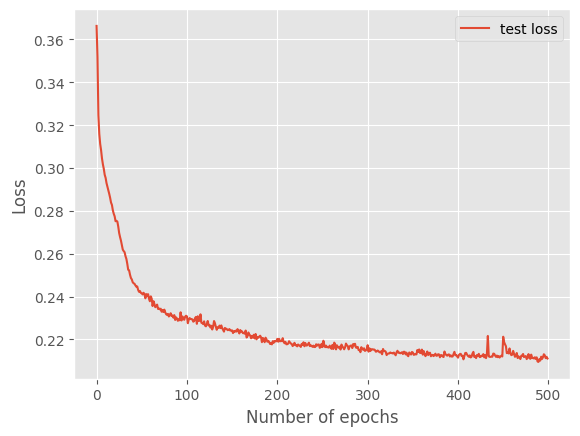

In [13]:
plt.plot(test_loss, label="test loss")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.legend()

In [14]:
p = 4231 # select any point to test the model
print( state_trainsition_model(testing_set[p, :n*state_space_size]))
print(testing_set[p, n*state_space_size:])
criterion(state_trainsition_model(testing_set[p, :n*state_space_size]), testing_set[p, n*state_space_size:] ).item()

tensor([ 0.7928, -0.3587, -0.1491,  0.1571], grad_fn=<AddBackward0>)
tensor([ 0.8638, -0.5884, -0.2533,  0.6084])


0.21402642130851746

In [15]:
expert_states = to_input(expert_states,  actions=None, n=n, compare=5)
expert_states = expert_states.detach().numpy()
np.random.shuffle(expert_states)
expert_states = torch.tensor(expert_states)

# state_trainsition_model = torch.load("Walker_transition_model_from_exploration_states_l1_n=2")
infered_expert_actions = state_trainsition_model(expert_states)
infered_expert_actions = torch.clamp(infered_expert_actions, -1, 1)

In [16]:
infered_expert_actions  = state_trainsition_model(expert_states).detach().numpy()
infered_expert_actions = torch.tensor(infered_expert_actions, requires_grad=False)
infered_expert_actions = torch.clamp(infered_expert_actions, -1, 1)

new_data = torch.cat((expert_states[:, :state_space_size], infered_expert_actions),1)

n_samples = int(new_data.shape[0]*0.7)
training_set = new_data[:n_samples]
testing_set = new_data[n_samples:]
print("training_set", training_set.shape)
print("testing_set", testing_set.shape)

training_set torch.Size([173442, 28])
testing_set torch.Size([74333, 28])


In [17]:
# Network arch, loss function and optimizer

bco_walker = nn.Sequential(
    nn.Linear(state_space_size,60),
    nn.ReLU(),
    
    nn.Linear(60,100),
    nn.ReLU(),
    
    nn.Linear(100,60),
    nn.ReLU(),
    
    nn.Linear(60,40),
    nn.ReLU(),
    
    nn.Linear(40,10),
    nn.ReLU(),
    
    nn.Linear(10,action_space_size),
)

# criterion = nn.L1Loss()
criterion = nn.MSELoss()

In [18]:
# Train BCO model 
loss_list = []
test_loss = []

learning_rate = 0.001
optimizer = torch.optim.Adam(bco_walker.parameters(), lr = learning_rate) 

batch_size = 256
n_epoch = 500

for itr in range(n_epoch):
    total_loss = 0
    b=0
    for batch in range (0,training_set.shape[0], batch_size):
        data   = training_set  [batch : batch+batch_size , :state_space_size]
        y      = training_set  [batch : batch+batch_size, state_space_size:]
        y_pred = bco_walker(data)
        loss   = criterion(y_pred, y)
        total_loss += loss.item() 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        b += 1
    print("[EPOCH]: %i, [LOSS]: %.6f" % (itr+1, total_loss / b))
    display.clear_output(wait=True)
    loss_list.append(total_loss / b)
    x = testing_set[:, :state_space_size]
    y = testing_set[:,state_space_size:]
    y_pred = bco_walker(x)
    test_loss.append(criterion(y_pred, y).item())

[EPOCH]: 500, [LOSS]: 0.081960


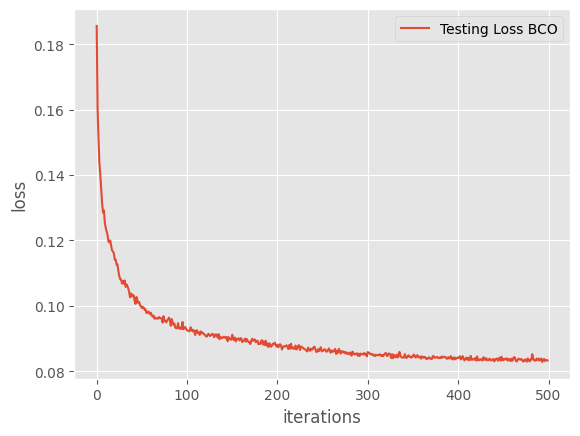

In [19]:
# plot test loss for BCO
# torch.save(bco_walker, "bco_walker_n=2") #uncomment to save model
plt.plot(test_loss, label="Testing Loss BCO")
plt.xlabel("iterations")
plt.ylabel("loss")
plt.legend()
plt.show()

In [20]:
p = 1234# select any point to test the model
print( bco_walker(testing_set[p, :state_space_size]))
print(testing_set[p, state_space_size:])
criterion(bco_walker(testing_set[p, :state_space_size]), testing_set[p, state_space_size:] ).item()

tensor([-0.2055,  0.7277,  0.3575,  0.3999], grad_fn=<AddBackward0>)
tensor([-0.1576,  0.6948,  0.3364,  0.1215])


0.09507501125335693

In [21]:
################################## parameters ##################################
n=2 # window size
n_iterations = 100 # max number of interacting with environment
n_ep = 1000 # number of epoches
max_steps = 500 # max timesteps per epoch
gamma = 1.0 # discount factor
seeds = np.zeros(n_iterations) # random seeds
target_reward = 0 # stop training when reward > targit_reward
################################## parameters ##################################


seed_reward_mean = []
seed_reward  = []

for itr in range (n_iterations):
   ################################## interact with env ##################################
    G= []
    G_mean = []
    env.seed(int(seeds[itr]))
    torch.manual_seed(int(seeds[itr]))
    torch.cuda.manual_seed_all(int(seeds[itr]))

    states_from_env  = -5*np.ones((n_ep, max_steps, state_space_size)) # states in
    actions_from_env = -5*np.ones((n_ep, max_steps, action_space_size))
    
    for ep in range (n_ep):
        state = env.reset()
        rewards = []
        R=0
        for t in range (max_steps):
            action = bco_walker(torch.tensor(state, dtype=torch.float))
            
            action = np.clip(action.detach().numpy(), -2,2) # clip action to be between (-1, 1)
            
            states_from_env[ep,t]  = state
            actions_from_env[ep,t] = action
            next_state , r, done, _   = env.step(action)
            rewards.append(r)
            state = next_state
            if done:
                break
        R = sum([rewards[i]*gamma**i for i in range (len(rewards))])
        G.append(R)
        G_mean.append(np.mean(G))
        
        
        if ep % 1 ==0:
            print("ep = {} , Mean Reward = {:.6f}".format(ep, R))
        display.clear_output(wait=True)
    seed_reward.append(G)
    seed_reward_mean.append(G_mean)
    
    print("Itr = {} overall reward  = {:.6f} ".format(itr, np.mean(seed_reward_mean[-1])))
    print("Interacting with environment finished")

        
    if np.mean(seed_reward_mean[-1]) > target_reward:
        torch.save(bco_walker, "bco_walker={}_BCO({})_best_{}_expert_states".format(n,itr,expert_states.shape[0]))        
        break
    ################################ prepare collected states and actions ##################################
    
    states_from_env = torch.tensor(states_from_env, dtype=torch.float)
    actions_from_env = torch.tensor(actions_from_env, dtype=torch.float)
    states_from_env, actions_from_env = to_input(states_from_env, actions_from_env , n=n, compare=5)
    data_env = torch.cat((states_from_env, actions_from_env), 1).detach().numpy()
    np.random.shuffle(data_env)
    data_env = torch.tensor(data_env)
    print("data_env", data_env.shape)
    
    #################################  Update Transition Model and return infeered expert actions ##################################
    
    state_trainsition_model = train_transition( data_env ,  state_trainsition_model,  n=n )
    infered_expert_actions  = state_trainsition_model( torch.tensor(expert_states) )
    infered_expert_actions = torch.tensor( infered_expert_actions, requires_grad=False )
    print("Updated Transition Model and returned infeered expert actions")
    
    ################################# Update BC model ##################################
    
    expert_data = torch.cat((expert_states[:, :state_space_size], infered_expert_actions),1)
    bco_walker = train_BC(expert_data, bco_walker, n_epoch =50)
    print(" Updated BC model itra= {}".format(itr))
    print("finished")
    
print(" Updated BC model itra= {}".format(itr))

Itr = 3 overall reward  = 63.711299 
Interacting with environment finished
 Updated BC model itra= 3


In [32]:
seed_reward

[[240.77802927209146,
  238.81871533231615,
  -75.50092236422748,
  44.88503984016688,
  238.4985269714502,
  -52.739356738886485,
  35.14107059655029,
  -14.022194402478632,
  -67.96271077872814,
  -88.42320467627484,
  47.536467907173034,
  89.86683668442976,
  -43.83194475273109,
  239.48659427787914,
  52.16173618306905,
  99.1171055693519,
  -82.85752805168183,
  -96.24978974268213,
  21.157585206522285,
  -98.36721801348341,
  241.00247982381586,
  240.76875256783646,
  -31.244562960744545,
  -32.58222478751904,
  16.38246091053324,
  240.1901132319459,
  -11.540399433454525,
  26.276004277527335,
  237.05704050212046,
  14.419775211693747,
  -49.185635731393454,
  -10.813833224243197,
  52.13994324043156,
  71.3815381893341,
  237.94730697635663,
  238.86503784058044,
  78.3106831534146,
  -55.887524296517185,
  235.63019117714222,
  241.82148145372943,
  14.793340371871992,
  -33.67396306183251,
  -84.9441650330263,
  -65.79548308837788,
  -95.71079222324491,
  -66.992224809825

In [22]:
x = itr
n_iterations = 2
n_ep = 1000
max_steps = 500
gamma = 1.0 # discount factor
seeds = [684, 559, 629, 192, 835]


seed_reward_mean = []
seed_reward  = []
for itr in range (n_iterations):
   ################################## interact with env ##################################
    G= []
    G_mean = []
    env.seed(int(seeds[itr]))
    torch.manual_seed(int(seeds[itr]))
    torch.cuda.manual_seed_all(int(seeds[itr]))

    for ep in range (n_ep):
        state = env.reset()
        rewards = []
        R=0
        for t in range (max_steps):      
            action = bco_walker(torch.tensor(state, dtype=torch.float))
            action = np.clip(action.detach().numpy(), -1,1)
            next_state , r, done, _   = env.step(action)
            rewards.append(r)
            state = next_state
            if done:
                break
        R = sum([rewards[i]*gamma**i for i in range (len(rewards))])
        G.append(R)
        G_mean.append(np.mean(G))
        if ep % 1 ==0:
            print("ep = {} , Mean Reward = {:.6f}".format(ep, R))
        display.clear_output(wait=True)
    seed_reward.append(G)
    seed_reward_mean.append(G_mean)
    print("Itr = {} overall reward  = {:.6f} ".format(itr, np.mean(seed_reward_mean[-1])))
    print("Interacting with environment finished")
# np.save("reward_mean_walker_n={}_bco({})_expert_states={}".format(n, x , expert_states.shape[0]), seed_reward_mean) #uncomment to save the rrward over 5 random seeds

Itr = 1 overall reward  = 71.166166 
Interacting with environment finished


In [23]:
seed_reward_mean_bco = np.array(seed_reward_mean)
mean_bco  = np.mean(seed_reward_mean_bco,axis=0)
std_bco  = np.std(seed_reward_mean_bco,axis=0)

In [30]:
TRPO_mean  = np.load("reward_exprt_TRPO.npy")
mean_expert= np.mean(TRPO_mean,axis=0)
std_expert = np.std(TRPO_mean,axis=0)

In [31]:
mean_expert

array([268.10017911, 232.92597497, 270.30364616, 269.06015111,
       271.211877  , 269.53814113, 269.52132435, 271.73659769,
       235.18366642, 240.51061488, 269.26141836, 269.48181592,
       269.63626204, 270.21037872, 270.01474625, 268.10333277,
       270.21536516, 269.56840284, 269.77038035, 269.15047696,
       269.13196904, 269.57387148, 268.7535194 , 271.00894194,
       269.09300564, 270.30493823, 269.06846645, 221.67127567,
       268.73886041, 268.9369819 , 234.70249235, 269.89141426,
       269.40955965, 269.04788751, 243.13377333, 216.79045204,
       174.04861561, 270.24317051, 271.31010184, 270.41176944,
       269.48376028, 269.18551204, 269.06050309, 269.31135925,
       270.08065856, 269.7828579 , 267.91246973, 269.97645377,
       269.24158763, 270.40374593, 269.72468347, 269.94303231,
       268.7738433 , 232.77181094, 218.30589177, 221.74305659,
       271.22416997, 270.59162362, 270.45653685, 270.28975428,
       270.0880183 , 268.46755683, 268.86902649, 223.29